# Libraries

In [2]:
# !pip install tensorflow_text

In [3]:
#import tensorflow_text as text
import pandas as pd
from tensorflow.keras import Sequential
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import re
import nltk
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam
from keras.optimizers import SGD
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import spacy
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#spacy_eng = spacy.load("en_core_web_sm")
nltk.download('stopwords')
lemm = WordNetLemmatizer()
plt.rcParams['figure.figsize'] = (20,8)
plt.rcParams['font.size'] = 18

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Getting the data

In [5]:
df_1 = pd.read_json('Sarcasm_Headlines_Dataset.json', lines=True)
df_2 = pd.read_json('Sarcasm_Headlines_Dataset_v2.json', lines=True)

In [6]:
df = pd.concat([df_1, df_2])

In [7]:
df = df.reset_index(drop=True)
df = df.drop(df.columns[0], axis=1) # remove arcticle link column

In [8]:
df

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0
...,...,...
55323,jews to celebrate rosh hashasha or something,1
55324,internal affairs investigator disappointed con...,1
55325,the most beautiful acceptance speech this week...,0
55326,mars probe destroyed by orbiting spielberg-gat...,1


### check for null

In [9]:
has_null_values = df.isnull().sum()
has_null_values

headline        0
is_sarcastic    0
dtype: int64

# Visualize the Data

### Data count

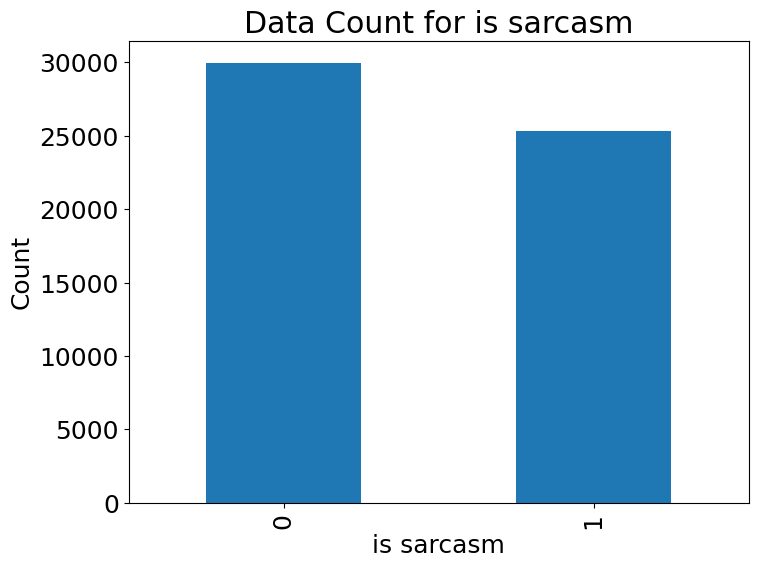

In [10]:
# Get the counts for the last column
counts = df.iloc[:, -1].value_counts()

# Plot the counts
plt.figure(figsize=(8, 6))
counts.plot(kind='bar')
plt.xlabel('is sarcasm')
plt.ylabel('Count')
plt.title('Data Count for is sarcasm')
plt.show()

### Cleaning Data
removing white spaces, uppercase, stop words and lemmatizing the words

In [11]:
stop_words = stopwords.words('english')

def text_cleaning(x):

    headline = re.sub('\s+\n+', ' ', x)
    headline = re.sub('[^a-zA-Z0-9]', ' ', x)
    headline = headline.lower()
    headline = headline.split()

    headline = [lemm.lemmatize(word, "v") for word in headline if not word in stop_words]
    headline = ' '.join(headline)

    return headline


In [12]:
df['clean_headline'] = df['headline'].apply(text_cleaning)

In [13]:
df

,headline,is_sarcastic,clean_headline
0,former versace store clerk sues over secret 'b...,0,former versace store clerk sue secret black co...
1,the 'roseanne' revival catches up to our thorn...,0,roseanne revival catch thorny political mood b...
2,mom starting to fear son's web series closest ...,1,mom start fear son web series closest thing gr...
3,"boehner just wants wife to listen, not come up...",1,boehner want wife listen come alternative debt...
4,j.k. rowling wishes snape happy birthday in th...,0,j k rowling wish snape happy birthday magical way
...,...,...,...
55323,jews to celebrate rosh hashasha or something,1,jews celebrate rosh hashasha something
55324,internal affairs investigator disappointed con...,1,internal affairs investigator disappoint consp...
55325,the most beautiful acceptance speech this week...,0,beautiful acceptance speech week come queer ko...
55326,mars probe destroyed by orbiting spielberg-gat...,1,mar probe destroy orbit spielberg gate space p...


### common words for sarcastic vs non_sarcastic

In [14]:
sarcastic = df[df['is_sarcastic']==1]['clean_headline'].tolist()
non_sarcastic = df[df['is_sarcastic']==0]['clean_headline'].tolist()

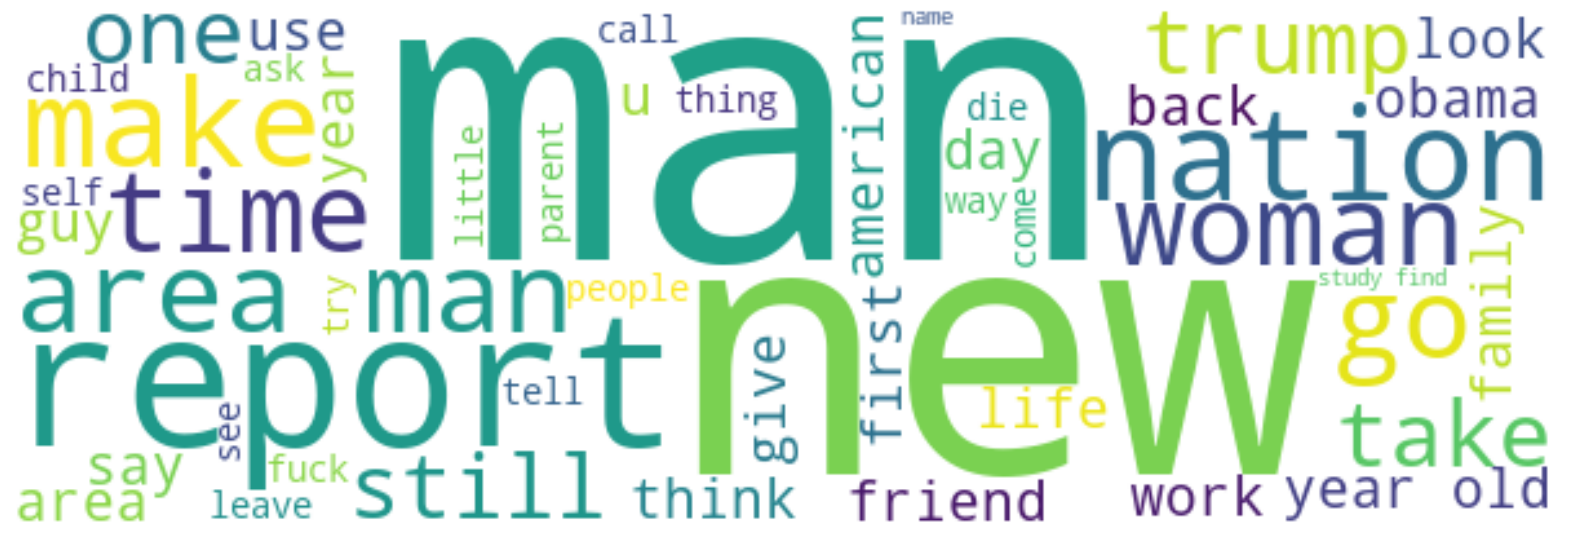

In [15]:
wordcloud = WordCloud(max_words=50, width=600, background_color='white').generate(" ".join(sarcastic))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

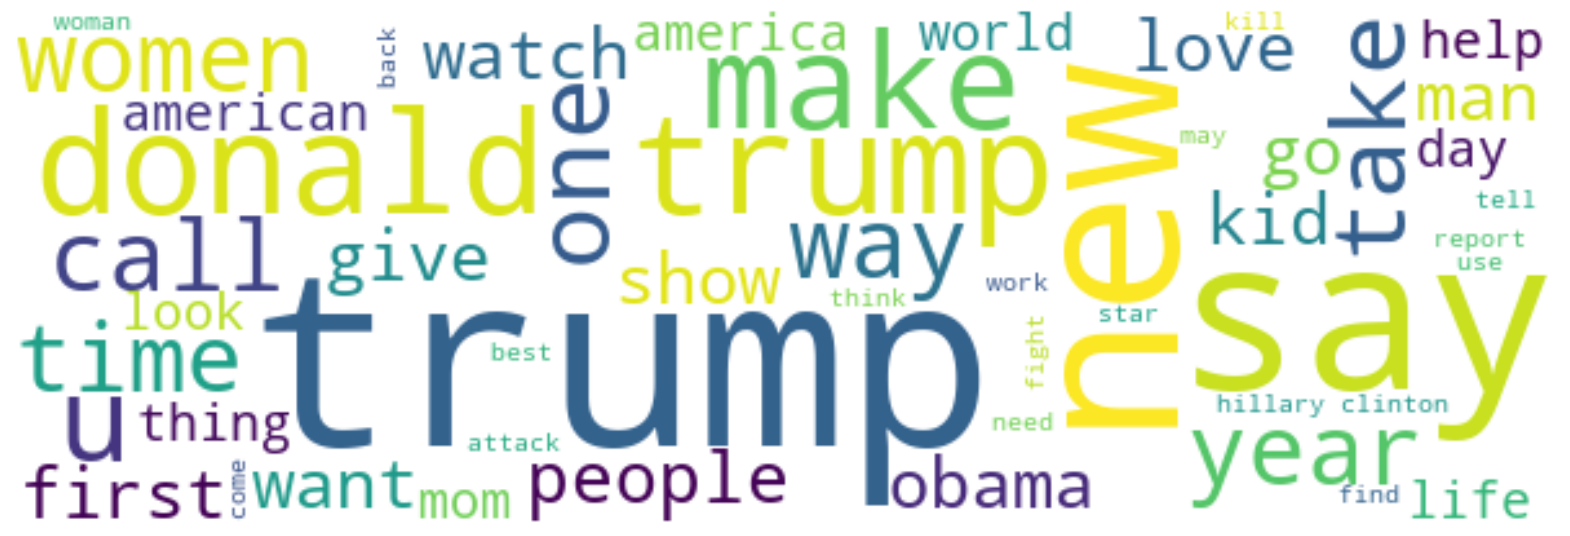

In [16]:
wordcloud = WordCloud(max_words=50, width=600, background_color='white').generate(" ".join(non_sarcastic))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Adding features

### text length

Text(0.5, 1.0, 'Not Sarcastic text length')

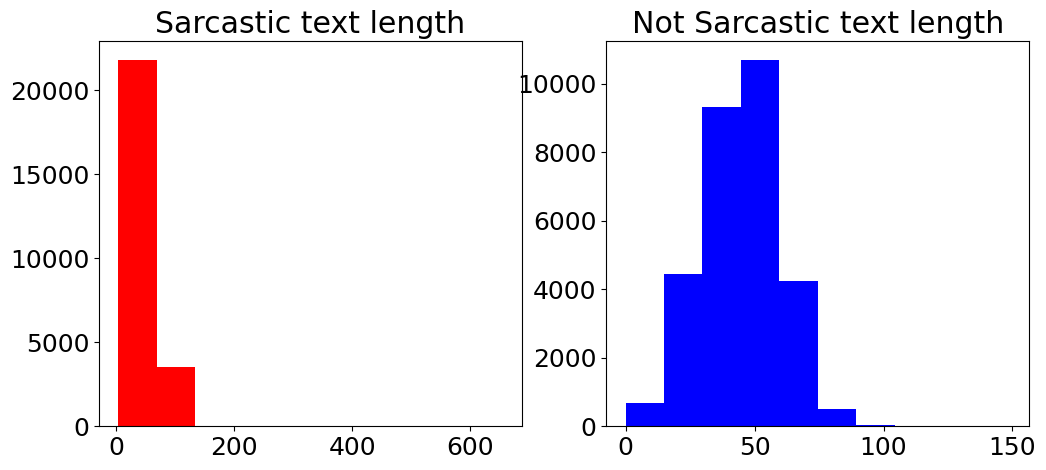

In [17]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,5))
ax1.hist([len(x) for x in sarcastic],color='red')
ax1.set_title('Sarcastic text length')
ax2.hist([len(x) for x in non_sarcastic],color='blue')
ax2.set_title('Not Sarcastic text length')

### word count

Text(0.5, 1.0, 'Not Sarcastic text word count')

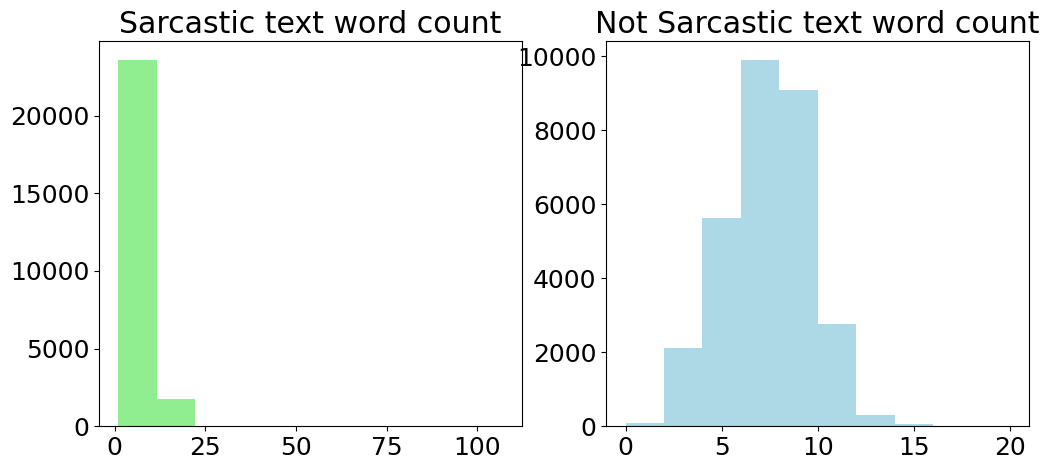

In [18]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,5))
text_len=df[df['is_sarcastic']==1]['clean_headline'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='lightgreen')
ax1.set_title('Sarcastic text word count')
text_len=df[df['is_sarcastic']==0]['clean_headline'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='lightblue')
ax2.set_title('Not Sarcastic text word count')

In [19]:
df = df.drop('headline', axis=1)
text_len = [len(x) for x in df['clean_headline']]
word_count = df['clean_headline'].str.split().map(lambda x: len(x))
df['text_len'] = text_len
df['word_count'] = word_count
df

,is_sarcastic,clean_headline,text_len,word_count
0,0,former versace store clerk sue secret black co...,66,10
1,0,roseanne revival catch thorny political mood b...,57,8
2,1,mom start fear son web series closest thing gr...,54,9
3,1,boehner want wife listen come alternative debt...,62,9
4,0,j k rowling wish snape happy birthday magical way,49,9
...,...,...,...,...
55323,1,jews celebrate rosh hashasha something,38,5
55324,1,internal affairs investigator disappoint consp...,62,8
55325,0,beautiful acceptance speech week come queer ko...,50,7
55326,1,mar probe destroy orbit spielberg gate space p...,51,8


# Tokenazation

### drop rows with 0 words

In [20]:
rows_with_zero_words = df[df['word_count'] == 0]
df = df.drop(rows_with_zero_words.index)

### check for max word count

In [21]:
max_word_count = df['word_count'].max()
max_word_count

107

### drop row with 107 word count

In [22]:
max_row = df[df['word_count'] == max_word_count]
df = df.drop(max_row.index)
df.reset_index(inplace=True, drop=True)
df['word_count'].max()

31

### get input and output X, Y

In [23]:
X = df["clean_headline"]
Y = df["is_sarcastic"].values
print(Y[:2])
print(X[1])

[0 0]
roseanne revival catch thorny political mood better worse


### tokenizer

In [24]:
tokenize = Tokenizer(oov_token="<oov>")
tokenize.fit_on_texts(X)
word_idx = tokenize.word_index

data_seqence = tokenize.texts_to_sequences(X)
pad_seq = pad_sequences(data_seqence, padding="pre", truncating="pre")

print("The Padding Sequance Shape is  --> ", pad_seq.shape)

The Padding Sequance Shape is  -->  (55325, 31)


In [25]:
input_length = max(len(seq) for seq in data_seqence)

vocabulary_size = len(word_idx) + 1

input_length, vocabulary_size

(31, 21361)

### Put all features together

In [26]:
# Reshape the columns to match the shape of `pad_seq`
word_count = np.array(df['word_count']).reshape(-1, 1)
text_len = np.array(df['text_len']).reshape(-1, 1)

# Concatenate `pad_seq`, `word_count`, and `text_len`
features = np.concatenate((pad_seq, word_count, text_len), axis=1)

# Verify the shape of the resulting features array
print(features.shape)

(55325, 33)


In [27]:
features

array([[   0,    0,    0, ..., 7196,   10,   66],
       [   0,    0,    0, ..., 1004,    8,   57],
       [   0,    0,    0, ..., 8990,    9,   54],
       ...,
       [   0,    0,    0, ..., 1721,    7,   50],
       [   0,    0,    0, ..., 5432,    8,   51],
       [   0,    0,    0, ...,  101,    4,   21]], dtype=int64)

# Spilt Train , Test Data

In [28]:
x_train, x_test_full, y_train, y_test_full = train_test_split(features,Y, train_size=0.6)
x_test, x_cv, y_test, y_cv = train_test_split(x_test_full, y_test_full, train_size=0.5)
print(x_train.shape)
print(x_cv.shape)
print(x_test.shape)

(33195, 33)
(11065, 33)
(11065, 33)


In [29]:
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D


model = Sequential([
    Embedding(vocabulary_size, 50, input_length=input_length+2),
    GlobalAveragePooling1D(),
    Dense(48, activation="relu"), 
    Dense(1, activation="sigmoid")
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 33, 50)            1068050   
                                                                 
 global_average_pooling1d (G  (None, 50)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 48)                2448      
                                                                 
 dense_1 (Dense)             (None, 1)                 49        
                                                                 
Total params: 1,070,547
Trainable params: 1,070,547
Non-trainable params: 0
_________________________________________________________________


In [31]:
from tensorflow.keras.metrics import Precision, Recall


learning_rate = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3]
history_all = []

for lr in learning_rate:
    model.compile(
        loss=BinaryCrossentropy(),
        optimizer=Adam(lr),
        metrics=["accuracy", Precision(), Recall()]
    )
    history = model.fit(
        x_train, y_train, 
        epochs=30,
        batch_size=64,
        validation_data=(x_cv, y_cv),
        verbose=2,
    )
    history_all.append(history)

Epoch 1/30
519/519 - 9s - loss: 0.0245 - accuracy: 0.9921 - precision_1: 0.9924 - recall_1: 0.9903 - val_loss: 0.9330 - val_accuracy: 0.8875 - val_precision_1: 0.8800 - val_recall_1: 0.8750 - 9s/epoch - 18ms/step
Epoch 2/30
519/519 - 7s - loss: 0.0193 - accuracy: 0.9943 - precision_1: 0.9943 - recall_1: 0.9934 - val_loss: 0.9766 - val_accuracy: 0.8878 - val_precision_1: 0.8755 - val_recall_1: 0.8819 - 7s/epoch - 14ms/step
Epoch 3/30
519/519 - 8s - loss: 0.0176 - accuracy: 0.9948 - precision_1: 0.9949 - recall_1: 0.9938 - val_loss: 1.0214 - val_accuracy: 0.8881 - val_precision_1: 0.8891 - val_recall_1: 0.8650 - 8s/epoch - 15ms/step
Epoch 4/30
519/519 - 7s - loss: 0.0177 - accuracy: 0.9943 - precision_1: 0.9940 - recall_1: 0.9936 - val_loss: 1.0570 - val_accuracy: 0.8883 - val_precision_1: 0.8832 - val_recall_1: 0.8728 - 7s/epoch - 14ms/step
Epoch 5/30
519/519 - 7s - loss: 0.0157 - accuracy: 0.9955 - precision_1: 0.9956 - recall_1: 0.9946 - val_loss: 1.0946 - val_accuracy: 0.8833 - val_p

1


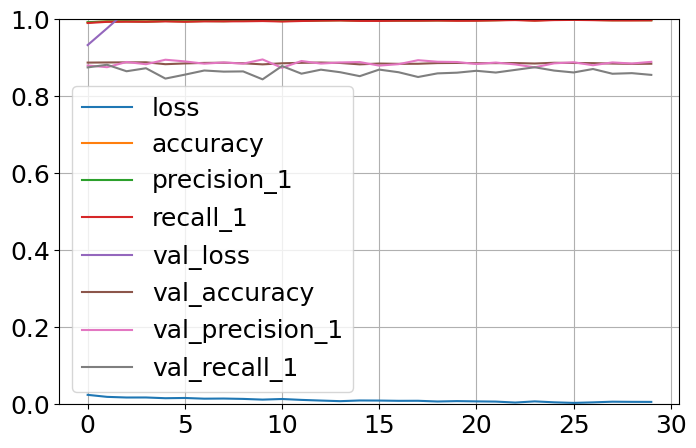

2


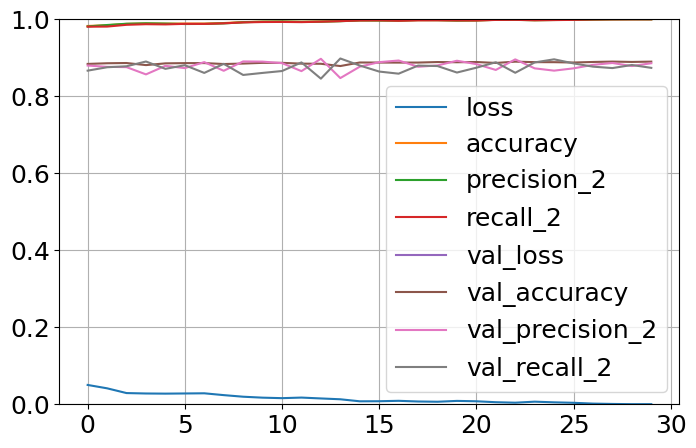

3


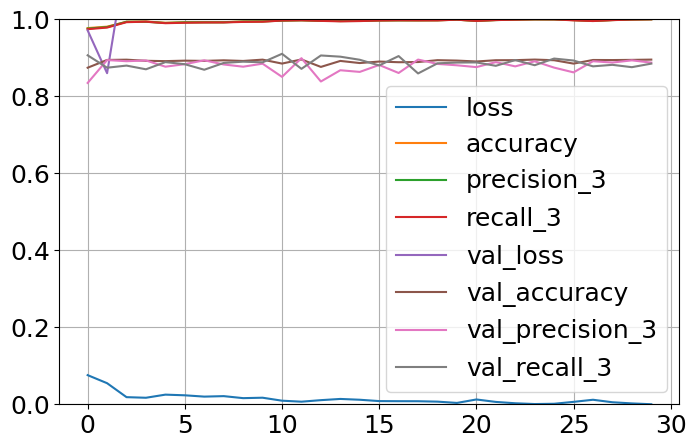

4


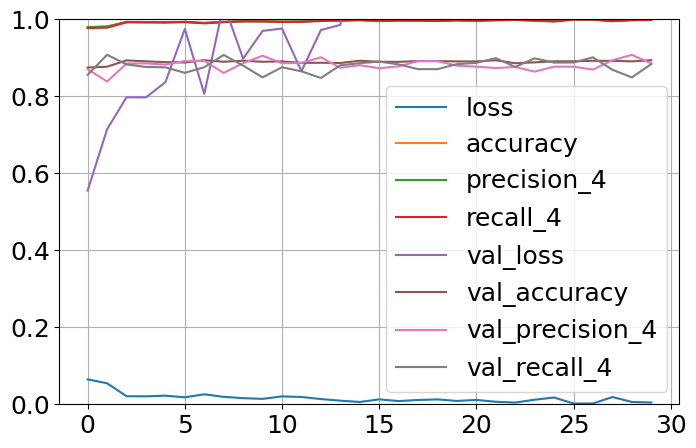

5


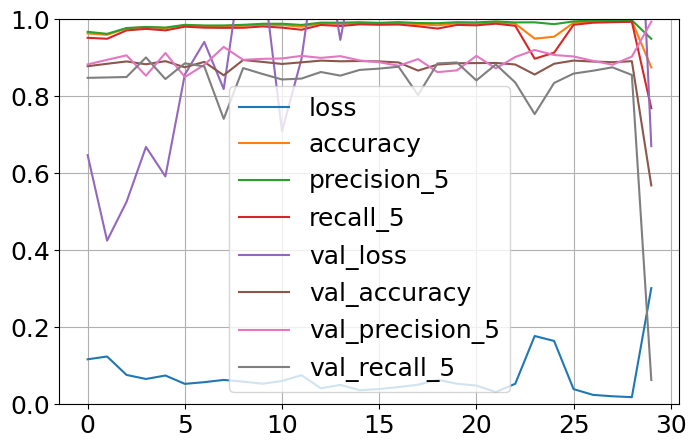

6


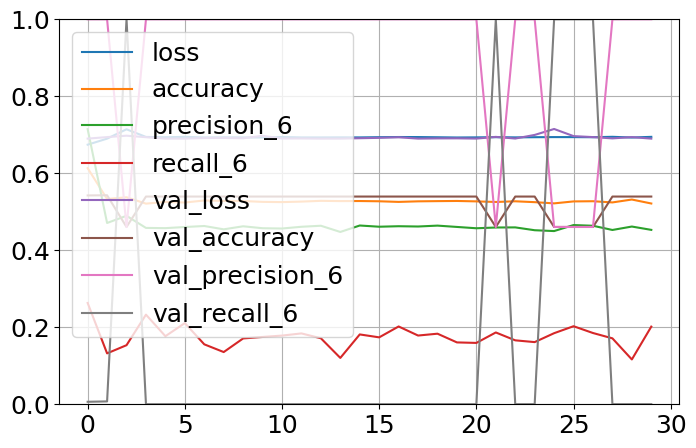

In [34]:
i = 1
for history in history_all:
    print(i)
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1) # set the vertical range to [0-1]
    plt.show()
    i += 1